### Read the train and test logits/likelyhoods

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import f1_score
from netcal.metrics import ECE
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from tqdm import tqdm
import pydensecrf.densecrf as dcrf
import optuna

PENALTY_FACTOR = 0.1   # higher penalty factor for CRF
ALPHA_FACTOR = 0.1   # penalty factor for lower bound

val_path = 'calibration_logits.pth'
test_path = 'test_logits.pth'

val_data = torch.load(val_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

val_logits = val_data["logits"] 
val_images = val_data["images"]  
val_labels = val_data["masks"]    
val_probs = F.softmax(val_logits, dim=1)

test_logits = test_data["logits"] 
test_images = test_data["images"]  
test_labels = test_data["masks"]    
test_probs = F.softmax(test_logits, dim=1)

print("Validation logits shape:", val_logits.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Validation probabilities shape:", val_probs.shape)       

Validation logits shape: torch.Size([21, 4, 966, 1296])
Validation images shape: torch.Size([21, 3, 966, 1296])
Validation labels shape: torch.Size([21, 966, 1296])
Validation probabilities shape: torch.Size([21, 4, 966, 1296])


### Frameworks

#### FrameMetrics

In [2]:
class FrameMetrics:

    def compute_ece(probs, labels, n_bins=10):
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C) 
        labels_flat = labels.view(-1)  # (N*H*W,)
        probs_np  = probs_flat.detach().cpu().numpy()  
        labels_np = labels_flat.detach().cpu().numpy() 
        
        ece = ECE(bins=n_bins)
        ece_score = ece.measure(probs_np, labels_np)
        return ece_score
    
    def compute_inbalance(labels):
        labels_flat = labels.view(-1)               
        labels_np   = labels_flat.detach().cpu().numpy()

        classes, counts = np.unique(labels_np, return_counts=True)
        total           = labels_np.shape[0]
        percentages     = counts / total * 100

        for cls, cnt, pct in zip(classes, counts, percentages):
            print(f"Classe {cls}: {cnt} samples — {pct:.2f}% of total")

        fig, ax = plt.subplots()
        bars = ax.bar(classes, counts)

        for bar, pct in zip(bars, percentages):
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                bar.get_height(),                   
                f'{pct:.2f}%',                      
                ha='center',                        
                va='bottom'                         
            )

        ax.set_xlabel('Index of class')
        ax.set_ylabel('Number of samples')
        ax.set_title('Class Distribution')
        ax.set_xticks(classes)
        plt.show()

    def compute_f1_score(probs, labels, num_classes): 
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  
        labels_flat = labels.view(-1)  

        preds_flat = torch.argmax(probs_flat, dim=1)
        labels_np = labels_flat.cpu().numpy()
        preds_np = preds_flat.cpu().numpy()

        f1_per_class = f1_score(labels_np, preds_np, average=None,
                                labels=range(num_classes), zero_division=0)

        macro_f1 = f1_score(labels_np, preds_np, average='macro',
                               labels=range(num_classes), zero_division=0)

        return f1_per_class, macro_f1

#### Frame Imprecise Probability

In [3]:
class FrameImpreciseProbsframe:
    def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):
        entropy = -torch.sum(probs * torch.log(probs + eps), dim=1) 
        lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       
        return lower_bound
    
    def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
        N, C, H, W = lower_bound.shape
        plt.figure(figsize=(8, 4))

        for c in range(C):
            mask = (labels == c).unsqueeze(1) 
            lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

            if lower_c.numel() > sample_size:
                indices = torch.randperm(lower_c.numel())[:sample_size]
                lower_c = lower_c[indices]

            sns.kdeplot(lower_c.cpu().numpy(), label=f'Class {c}', linewidth=2)

        plt.title("Distribution of Lower Bounds by Class")
        plt.xlabel("Lower Bound")
        plt.ylabel("Estimated Density")
        plt.legend()
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.grid(True)
        plt.show()
    

#### Frame CRF

In [4]:
class FrameCRFApproach:
    def __init__(self, num_classes: int, penalty_factor: float = 0.1, epsilon: float = 1e-8):
        self.num_classes = num_classes
        self.penalty_factor = penalty_factor
        self.epsilon = epsilon
        self.best_params = None
        self.thresholds_per_class = None
        self.class_threshold_values_tensor = None

    def set_optimal_thresholds(self, thresholds: dict):
        self.thresholds_per_class = thresholds
        self.class_threshold_values_tensor = torch.zeros(self.num_classes)
        for i in range(self.num_classes):
            self.class_threshold_values_tensor[i] = thresholds.get(f'class_{i}', {}).get('threshold_value', 0.0)

    def _prepare_unary_energies(self, probs: torch.Tensor, lower_bounds: torch.Tensor):
        if self.class_threshold_values_tensor is None:
            raise ValueError("Os limiares ótimos devem ser definidos com 'set_optimal_thresholds'.")
        
        device = probs.device
        self.class_threshold_values_tensor = self.class_threshold_values_tensor.to(device)
        
        adjusted_probs = probs.clone()
        predicted_classes = torch.argmax(probs, dim=0)

        threshold_for_each_pixel = self.class_threshold_values_tensor[predicted_classes.flatten()].reshape(predicted_classes.shape)
        confidence_score_for_each_pixel = torch.gather(lower_bounds, 0, predicted_classes.unsqueeze(0)).squeeze(0)
        
        uncertain_mask = (confidence_score_for_each_pixel < threshold_for_each_pixel)
        is_not_background_mask = (predicted_classes != 0)
        final_uncertain_mask = uncertain_mask & is_not_background_mask

        if torch.any(final_uncertain_mask):
            adjusted_probs_permuted = adjusted_probs.permute(1, 2, 0) # H, W, C
            one_hot_pred_class = torch.nn.functional.one_hot(predicted_classes, self.num_classes)
            
            original_probs_uncertain = adjusted_probs_permuted[final_uncertain_mask]
            penalized_probs = original_probs_uncertain * self.penalty_factor
            
            value_removed = original_probs_uncertain - penalized_probs
            value_removed_summed = torch.sum(value_removed * one_hot_pred_class[final_uncertain_mask], dim=1)

            adjusted_probs_permuted[final_uncertain_mask] = penalized_probs
            adjusted_probs_permuted[final_uncertain_mask, 0] += value_removed_summed

            sum_probs = torch.sum(adjusted_probs_permuted[final_uncertain_mask], dim=1, keepdim=True)
            adjusted_probs_permuted[final_uncertain_mask] /= sum_probs
            
            adjusted_probs = adjusted_probs_permuted.permute(2, 0, 1)

        return adjusted_probs.cpu().numpy()

    def _apply_crf_refinement(self, prob_unary: np.ndarray, sxy_gaussian: float, compat_gaussian: float, iterations: int = 10):
        C, H, W = prob_unary.shape
        d = dcrf.DenseCRF2D(W, H, C)
        unary = -np.log(np.maximum(prob_unary, self.epsilon)).reshape(C, -1).astype(np.float32)
        d.setUnaryEnergy(unary)
        d.addPairwiseGaussian(sxy=sxy_gaussian, compat=compat_gaussian)
        Q = d.inference(iterations)
        return np.array(Q).reshape((C, H, W))

    def _crf_loss_for_optimization(self, params: list, val_probs: torch.Tensor, val_lower_bounds: torch.Tensor, val_labels: torch.Tensor):
        n_samples = val_probs.shape[0]
        sxy_gaussian, compat_gaussian = params
        all_refined_probs = []

        pbar_desc = f"Optuna Trial (sxy={sxy_gaussian}, compat={compat_gaussian:.2f})"
        for i in tqdm(range(n_samples), desc=pbar_desc, leave=False):
            prepared_unary_np = self._prepare_unary_energies(
                val_probs[i], val_lower_bounds[i]
            )
            crf_refined_probs_np = self._apply_crf_refinement(
                prepared_unary_np, sxy_gaussian, compat_gaussian
            )
            all_refined_probs.append(torch.from_numpy(crf_refined_probs_np))

        all_refined_probs_tensor = torch.stack(all_refined_probs).to(val_labels.device)
        
        _, macro_f1 = FrameMetrics.compute_f1_score(
            all_refined_probs_tensor, val_labels, self.num_classes
        )
        return 1.0 - macro_f1

    def fit_crf_parameters(self, validation_probs: torch.Tensor, validation_lower_bounds: torch.Tensor, 
                           validation_labels: torch.Tensor, n_trials: int = 10):
        print("\n--- Starting CRF Parameter Optimization with Optuna ---")
        study = optuna.create_study(direction="minimize")
        objective_func = lambda trial: self._crf_loss_for_optimization(
            [trial.suggest_categorical("sxy_gaussian", [1, 3, 5]), trial.suggest_float("compat_gaussian", 1.0, 5.0)],
            validation_probs, validation_lower_bounds, validation_labels
        )
        study.optimize(objective_func, n_trials=n_trials)
        self.best_params = study.best_params
        print(f"--- CRF Optimization Completed. Best parameters: {self.best_params} ---")

    def inference_with_optimized_crf(self, test_probs: torch.Tensor, test_lower_bounds: torch.Tensor):
        if self.best_params is None or self.thresholds_per_class is None:
            raise ValueError("CRF parameters and class thresholds must be optimized/defined first.")

        print("\n--- Applying Optimized CRF on Test Set ---")
        n_samples = test_probs.shape[0]
        sxy = int(self.best_params["sxy_gaussian"])
        compat = float(self.best_params["compat_gaussian"])
        final_refined_probs_list = []

        for i in tqdm(range(n_samples), desc="Final Inference with CRF"):
            prepared_unary_np = self._prepare_unary_energies(
                test_probs[i], test_lower_bounds[i]
            )
            crf_refined_probs_np = self._apply_crf_refinement(
                prepared_unary_np, sxy, compat
            )
            final_refined_probs_list.append(torch.from_numpy(crf_refined_probs_np))

        final_refined_probs = torch.stack(final_refined_probs_list)
        final_predictions = final_refined_probs.argmax(dim=1)
        return final_refined_probs, final_predictions

#### Frame Threshold

##### Frame Quartile

In [5]:
class FrameQuartileApproach:
    @staticmethod
    def optimize_quartile_thresholds_per_class_bayesian(
        lower_bounds: torch.Tensor,
        labels: torch.Tensor,
        validation_probs: torch.Tensor,
        num_classes: int = 4,
        n_calls: int = 50,
        random_state: int = 42, 
        epsilon: float = 1e-8,
    ):
        N, C, H, W = lower_bounds.shape
        lower_bounds_flat = lower_bounds.permute(0, 2, 3, 1).reshape(-1, C)
        labels_flat = labels.view(-1)
        validation_probs_flat = validation_probs.permute(0, 2, 3, 1).reshape(-1, C)

        space = [Real(0.01, 0.99, name=f'quartile_threshold_class_{i}') for i in range(num_classes)]

        @use_named_args(space)
        def objective(**quartile_thresholds_args):
            current_threshold_values = torch.zeros(num_classes, device=lower_bounds.device)
            for i in range(num_classes):
                quartile_percentile = quartile_thresholds_args[f'quartile_threshold_class_{i}']
                class_i_mask = (labels_flat == i)
                if torch.sum(class_i_mask) > 0:
                    scores_for_class_i = lower_bounds_flat[class_i_mask, i]
                    threshold_value = np.percentile(scores_for_class_i.cpu().numpy(), quartile_percentile * 100)
                else:
                    threshold_value = 0.0
                current_threshold_values[i] = threshold_value

            adjusted_probs = validation_probs_flat.clone()
            predicted_class_orig_flat = torch.argmax(validation_probs_flat, dim=1)

            threshold_for_each_pixel = current_threshold_values[predicted_class_orig_flat]
            confidence_score_for_each_pixel = torch.gather(lower_bounds_flat, 1, predicted_class_orig_flat.unsqueeze(1)).squeeze(1)

            uncertain_mask = (confidence_score_for_each_pixel < threshold_for_each_pixel)
            
            is_not_background_mask = (predicted_class_orig_flat != 0)
            final_uncertain_mask = uncertain_mask & is_not_background_mask
            
            if torch.any(final_uncertain_mask):
                one_hot_pred_class = torch.nn.functional.one_hot(predicted_class_orig_flat, num_classes=num_classes)
                
                original_probs_uncertain = adjusted_probs[final_uncertain_mask]
                penalized_probs = original_probs_uncertain * PENALTY_FACTOR
                
                value_removed = original_probs_uncertain - penalized_probs
                value_removed_summed = torch.sum(value_removed * one_hot_pred_class[final_uncertain_mask], dim=1)
                adjusted_probs[final_uncertain_mask] = penalized_probs
                
                adjusted_probs[final_uncertain_mask, 0] += value_removed_summed
                
                adjusted_probs[final_uncertain_mask] /= torch.sum(adjusted_probs[final_uncertain_mask], dim=1, keepdim=True)
            
            adjusted_probs = torch.max(adjusted_probs, torch.tensor(epsilon, device=adjusted_probs.device))
            adjusted_probs = adjusted_probs / torch.sum(adjusted_probs, dim=1, keepdim=True)

            _, macro_f1 = FrameMetrics.compute_f1_score(
                adjusted_probs.reshape(N, H, W, C).permute(0, 3, 1, 2),
                labels,
                num_classes
            )
            return -macro_f1

        pbar = tqdm(total=n_calls, desc="Optimizing Thresholds")

        last_valid_res = None 

        def pbar_update(res_obj): 
            nonlocal last_valid_res 
            last_valid_res = res_obj 
            
            pbar.update(1)
            formatted_x = [f"{val:.4f}" for val in res_obj.x]
            pbar.set_description(f"Optimizing Thresholds: [{', '.join(formatted_x)}]")
            pbar.set_postfix({'Best F1 (Macro)': -res_obj.fun})

        min_delta = 1e-4
        patience = 5
        best_loss = float('inf')
        epochs_no_improve = 0
        
        callbacks = [pbar_update]

        def early_stopping_callback(res_obj): 
            nonlocal best_loss, epochs_no_improve
            current_loss = res_obj.fun 

            if current_loss < best_loss - min_delta:
                best_loss = current_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                raise StopIteration("Early stopping triggered: no improvement for too many iterations.")
            
            return False

        callbacks.append(early_stopping_callback)

        res = None 
        try:
            res = gp_minimize(
                objective,
                space,
                n_calls=n_calls,
                random_state=random_state,
                n_initial_points=max(5, len(space) * 2),
                acq_func="EI",
                callback=callbacks
            )
            
        except StopIteration as e:
            print(f"\n{e}")
            res = last_valid_res 
            
        if res is None:
            raise RuntimeError("Optimization did not return a result object. This might happen if early stopping triggers before n_initial_points.")

        pbar.close()

        best_quartile_thresholds = res.x
        best_macro_f1_from_optimization = -res.fun 

        final_threshold_values = {}
        for i in range(num_classes):
            class_i_mask = (labels_flat == i)
            
            if torch.sum(class_i_mask) > 0:
                scores_for_class_i = lower_bounds_flat[class_i_mask, i] 
                threshold_value = np.percentile(scores_for_class_i.cpu().numpy(), best_quartile_thresholds[i] * 100)
            else:
                threshold_value = 0.0

            final_threshold_values[f'class_{i}'] = {
                'quartile_percentile': best_quartile_thresholds[i],
                'threshold_value': threshold_value
            }

        print("Bayesian Optimization Completed (Class Thresholds):")
        print(f"  Best Macro F1-Score Found: {best_macro_f1_from_optimization:.4f}") 
        print("  Best Thresholds per Class:")
        for class_id, values in final_threshold_values.items():
            print(f"    {class_id}: Percentil={values['quartile_percentile']:.4f}, Valor={values['threshold_value']:.4f}")

        return {
            "best_per_class_thresholds": final_threshold_values,
            "best_macro_f1": best_macro_f1_from_optimization 
        }

### Check model calibration

In [6]:
ece_score = FrameMetrics.compute_ece(val_probs, val_labels, n_bins=10)
print(f"ECE Score: {ece_score:.4f}")

ECE Score: 0.0024


### Check class imbalance

Classe 0: 24946666 samples — 94.89% of total
Classe 1: 976055 samples — 3.71% of total
Classe 2: 327252 samples — 1.24% of total
Classe 3: 40683 samples — 0.15% of total


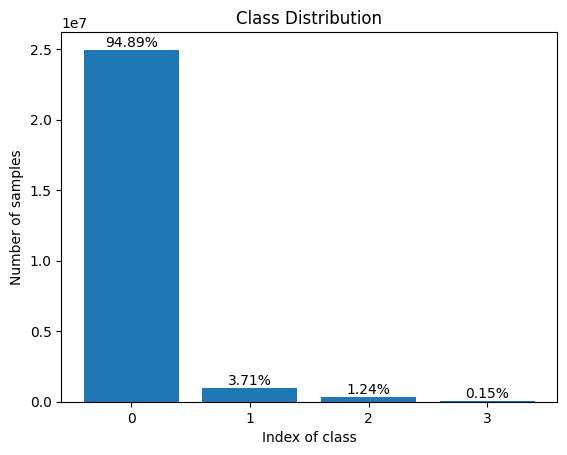

In [7]:
FrameMetrics.compute_inbalance(val_labels)

### Lower Bound

Lower Bound shape: torch.Size([21, 4, 966, 1296])


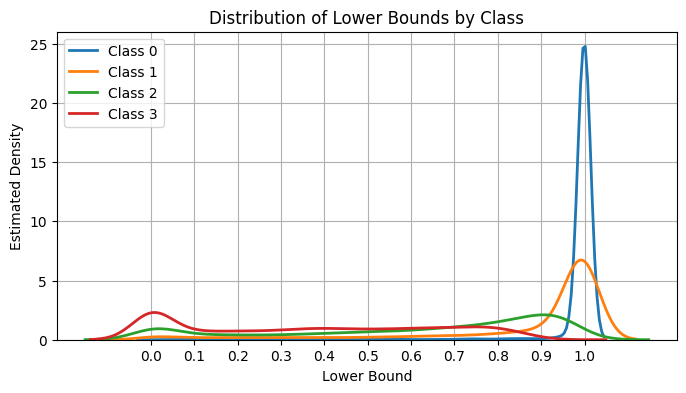

In [8]:
val_lower_bound = FrameImpreciseProbsframe.obtain_lower_bound(val_probs, alpha=ALPHA_FACTOR)
test_lower_bound = FrameImpreciseProbsframe.obtain_lower_bound(test_probs, alpha=ALPHA_FACTOR)
print(f"Lower Bound shape: {val_lower_bound.shape}") 
FrameImpreciseProbsframe.plot_lower_bound_distribution(val_lower_bound, val_labels, sample_size=10000)   

### Threshold

In [9]:
print("--- Step 1: Optimizing Confidence Thresholds per Class (using validation) ---")
threshold_results = FrameQuartileApproach.optimize_quartile_thresholds_per_class_bayesian(
    lower_bounds=val_lower_bound,
    labels=val_labels,
    validation_probs=val_probs,
    num_classes=4,
    n_calls=20
)

optimal_thresholds = threshold_results["best_per_class_thresholds"]
print("\nOptimal Thresholds per Class:")
for class_id, values in optimal_thresholds.items():
    print(f"  {class_id}: Quartile={values['quartile_percentile']:.4f}, Threshold={values['threshold_value']:.4f}")

--- Step 1: Optimizing Confidence Thresholds per Class (using validation) ---


Optimizing Thresholds: [0.9900, 0.0100, 0.1447, 0.3210]: 100%|██████████| 20/20 [03:57<00:00, 11.86s/it, Best F1 (Macro)=0.756]



Early stopping triggered: no improvement for too many iterations.
Bayesian Optimization Completed (Class Thresholds):
  Best Macro F1-Score Found: 0.7562
  Best Thresholds per Class:
    class_0: Percentil=0.9900, Valor=1.0000
    class_1: Percentil=0.0100, Valor=0.0000
    class_2: Percentil=0.1447, Valor=0.1361
    class_3: Percentil=0.3210, Valor=0.1349

Optimal Thresholds per Class:
  class_0: Quartile=0.9900, Threshold=1.0000
  class_1: Quartile=0.0100, Threshold=0.0000
  class_2: Quartile=0.1447, Threshold=0.1361
  class_3: Quartile=0.3210, Threshold=0.1349


### CRF

#### Train

In [10]:
print("\n--- Step 2: Optimizing CRF Parameters (using validation and optimal thresholds) ---")

crf_optimizer = FrameCRFApproach(num_classes=4, penalty_factor=PENALTY_FACTOR)
crf_optimizer.set_optimal_thresholds(optimal_thresholds)

crf_optimizer.fit_crf_parameters(
    validation_probs=val_probs,
    validation_lower_bounds=val_lower_bound, 
    validation_labels=val_labels,
    n_trials=10
)

print(f"\nOptimal CRF Parameters: {crf_optimizer.best_params}")

[I 2025-07-31 08:46:47,442] A new study created in memory with name: no-name-52b1aaa3-253c-45cf-b41f-e0b7cc4fa9a9



--- Step 2: Optimizing CRF Parameters (using validation and optimal thresholds) ---

--- Starting CRF Parameter Optimization with Optuna ---


[I 2025-07-31 08:47:23,626] Trial 0 finished with value: 0.26213957781017627 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 3.650826527882888}. Best is trial 0 with value: 0.26213957781017627.
[I 2025-07-31 08:48:00,161] Trial 1 finished with value: 0.24911275512808606 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 4.301724180797262}. Best is trial 1 with value: 0.24911275512808606.
[I 2025-07-31 08:48:36,084] Trial 2 finished with value: 0.2688098663160421 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 4.465415714663473}. Best is trial 1 with value: 0.24911275512808606.
[I 2025-07-31 08:49:12,661] Trial 3 finished with value: 0.2465416244950014 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 3.039594019855235}. Best is trial 3 with value: 0.2465416244950014.
[I 2025-07-31 08:49:49,191] Trial 4 finished with value: 0.24939621445547344 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 4.452847854231134}. Best is trial 3 with value: 0.2465416244950014.

--- CRF Optimization Completed. Best parameters: {'sxy_gaussian': 5, 'compat_gaussian': 1.0887908623339526} ---

Optimal CRF Parameters: {'sxy_gaussian': 5, 'compat_gaussian': 1.0887908623339526}


#### Inference

In [11]:
print("\n--- Step 3: Performing Final Inference and Evaluation (using test data) ---")

final_refined_probs_test, final_predictions_test = crf_optimizer.inference_with_optimized_crf(
    test_probs=test_probs,
    test_lower_bounds=test_lower_bound
)



--- Step 3: Performing Final Inference and Evaluation (using test data) ---

--- Applying Optimized CRF on Test Set ---


Final Inference with CRF: 100%|██████████| 43/43 [00:51<00:00,  1.20s/it]


### FINAL PERFORMANCE

In [12]:
print("\n--- Performance Results (Macro F1-Score and Per Class) ---")

print("\n## Baseline (Deep Learning Model Only)")
baseline_f1_per_class, baseline_macro_f1 = FrameMetrics.compute_f1_score(test_probs, test_labels, num_classes=4)
print(f"F1-Score (Macro): {baseline_macro_f1:.4f}")
print("F1-Score Per Class:")
for i, f1 in enumerate(baseline_f1_per_class):
    print(f"  Class {i}: {f1:.4f}")

print("\n## Your Refined Approach (DL + Thresholds + CRF)")
refined_f1_per_class, refined_macro_f1 = FrameMetrics.compute_f1_score(final_refined_probs_test, test_labels, num_classes=4)
print(f"F1-Score (Macro): {refined_macro_f1:.4f}")
print("F1-Score Per Class:")
for i, f1 in enumerate(refined_f1_per_class):
    print(f"  Class {i}: {f1:.4f}")

print("\n## Improvement Analysis")
if refined_macro_f1 > baseline_macro_f1:
    improvement = (refined_macro_f1 - baseline_macro_f1) / baseline_macro_f1 * 100
    print(f"Overall Improvement (Macro F1): Method improved the Macro F1-Score by {improvement:.2f}%.")
elif refined_macro_f1 < baseline_macro_f1:
    drop = (baseline_macro_f1 - refined_macro_f1) / baseline_macro_f1 * 100
    print(f"Overall Decline (Macro F1): Method decreased the Macro F1-Score by {drop:.2f}%.")
else:
    print("No significant change in Macro F1-Score.")

print("\nProcess Completed! Check the F1-Scores per class for detailed insights.")


--- Performance Results (Macro F1-Score and Per Class) ---

## Baseline (Deep Learning Model Only)
F1-Score (Macro): 0.7499
F1-Score Per Class:
  Class 0: 0.9914
  Class 1: 0.9290
  Class 2: 0.6680
  Class 3: 0.4111

## Your Refined Approach (DL + Thresholds + CRF)
F1-Score (Macro): 0.7503
F1-Score Per Class:
  Class 0: 0.9915
  Class 1: 0.9290
  Class 2: 0.6705
  Class 3: 0.4102

## Improvement Analysis
Overall Improvement (Macro F1): Method improved the Macro F1-Score by 0.06%.

Process Completed! Check the F1-Scores per class for detailed insights.
